<a href="https://colab.research.google.com/github/eduion/DeepRL/blob/main/HW4/HW4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HW4-2

Double DQN（Double Deep Q-Network）
傳統 DQN 在更新 Q 值時容易過度高估未來回報（Overestimation Bias），因為它在更新時同時用 max(Q) 選動作與評估動作。

Double DQN 將這兩個步驟拆開來：

使用 online model 選擇動作（argmax）。

使用 target model 評估該動作的價值。

更新公式為： $$
Q_{\text{target}} = r + \gamma \cdot Q_{\text{target}}(s', \arg\max Q_{\text{online}}(s'))
$$

Dueling DQN（Dueling Deep Q-Network）
Dueling DQN 改變了網路架構，將每個動作的 Q 值拆成兩部分：

狀態的整體價值
𝑉
(
𝑠
)
V(s)

各動作相對於平均的優勢值
𝐴
(
𝑠
,
𝑎
)
A(s,a)

結合的方式為：$$
Q(s, a) = V(s) + \left( A(s, a) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a') \right)
$$

In [1]:
# 1. 下載並使用外部 Gridworld.py 和 GridBoard.py
# 請將下列 URL 換成 raw 檔案的連結
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py

In [4]:
import random
import numpy as np
import torch
from Gridworld import Gridworld
from collections import deque
from matplotlib import pylab as plt
from IPython.display import clear_output

# 網路架構不變
L1, L2, L3, L4 = 64, 150, 100, 4
policy_net = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), torch.nn.ReLU(),
    torch.nn.Linear(L3, L4)
)
target_net = torch.nn.Sequential(  # 複製一份當作目標網路
    torch.nn.Linear(L1, L2), torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), torch.nn.ReLU(),
    torch.nn.Linear(L3, L4)
)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-3)
gamma, epsilon = 0.9, 1.0

In [2]:
action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}

Training 完成，最後一個 step 的 loss = 0.2748


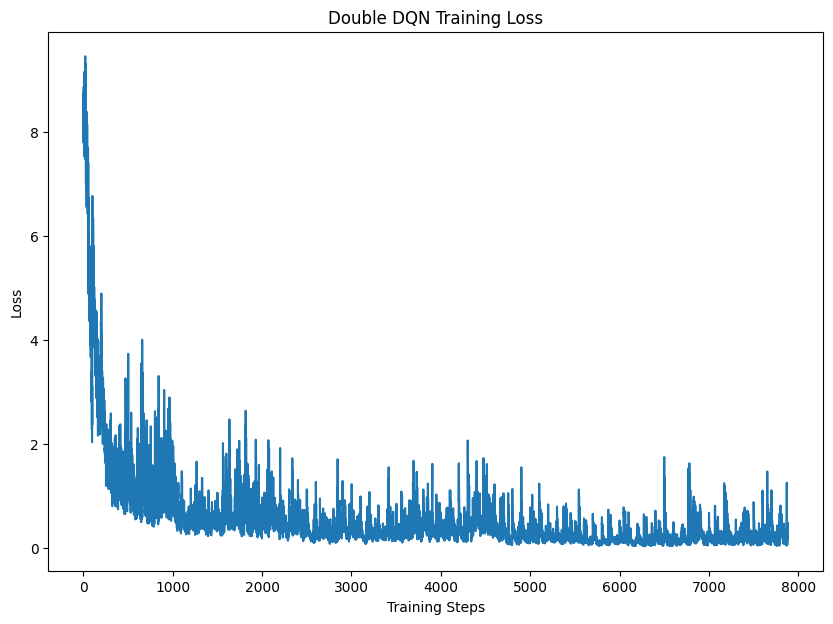

In [5]:
# Replay Buffer
mem_size, batch_size = 1000, 200
replay = deque(maxlen=mem_size)
target_update = 100  # 每100次 minibatch 更新後，同步 target
step_count = 0

losses = []
epochs, max_moves = 500, 50
last_loss = None
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state = torch.from_numpy(
        game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    ).float()
    done, mov = False, 0

    while not done:
        mov += 1
        qvals = policy_net(state)
        if random.random() < epsilon:
            act = random.randint(0,3)
        else:
            act = qvals.argmax().item()
        game.makeMove(action_set[act])
        next_state = torch.from_numpy(
            game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        ).float()
        reward = game.reward()
        done = (reward != -1) or (mov > max_moves)

        # 存入 replay buffer
        replay.append((state, act, reward, next_state, done))
        state = next_state

        # Double DQN 更新
        if len(replay) > batch_size:
            batch = random.sample(replay, batch_size)
            s1_b, a_b, r_b, s2_b, d_b = zip(*batch)
            s1_b = torch.cat(s1_b)
            s2_b = torch.cat(s2_b)
            a_b = torch.tensor(a_b, dtype=torch.long)
            r_b = torch.tensor(r_b, dtype=torch.float32)
            d_b = torch.tensor(d_b, dtype=torch.bool)

            # 1) 預測當前 Q
            Q1 = policy_net(s1_b).gather(1, a_b.unsqueeze(1)).squeeze()

            # 2) 用 policy_net 選最佳動作，用 target_net 評估該動作
            with torch.no_grad():
                next_q_policy = policy_net(s2_b)
                best_acts = next_q_policy.argmax(dim=1)
                next_q_target = target_net(s2_b)
                selected_q = next_q_target[range(batch_size), best_acts]

            Y = r_b + gamma * (~d_b).float() * selected_q

            loss = loss_fn(Q1, Y)
            if len(replay) > batch_size:
              print(f"epoch {i}: loss = {loss.item():.4f}")
              clear_output(wait=True)
              last_loss = loss.item()
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

              losses.append(loss.item())

            # 同步 target network
            step_count += 1
            if step_count % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

        if abs(reward) == 10:
            break

    epsilon = max(0.1, epsilon - 1/epochs)
print(f"Training 完成，最後一個 step 的 loss = {last_loss:.4f}")
# 畫 Loss
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Double DQN Training Loss")
plt.show()

In [22]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from Gridworld import Gridworld
from IPython.display import clear_output
import matplotlib.pyplot as plt

# 1) Dueling DQN 網路架構
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, n_actions):
        super(DuelingDQN, self).__init__()
        # 共享特徵層
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU()
        )
        # Value 分支
        self.value_head = nn.Sequential(
            nn.Linear(hidden_dim2, hidden_dim2 // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim2 // 2, 1)
        )
        # Advantage 分支
        self.adv_head = nn.Sequential(
            nn.Linear(hidden_dim2, hidden_dim2 // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim2 // 2, n_actions)
        )

    def forward(self, x):
        feat = self.shared(x)
        V = self.value_head(feat)                # [B,1]
        A = self.adv_head(feat)                  # [B,n_actions]
        Q = V + A - A.mean(dim=1, keepdim=True)  # 合併
        return Q

Episode 0 | Avg Loss: nan | Epsilon: 1.00 | Reward: -50
Episode 100 | Avg Loss: 0.0033 | Epsilon: 0.82 | Reward: -50
Episode 200 | Avg Loss: 0.0019 | Epsilon: 0.64 | Reward: -50
Episode 300 | Avg Loss: 0.0024 | Epsilon: 0.46 | Reward: -50
Episode 400 | Avg Loss: 0.0011 | Epsilon: 0.28 | Reward: -50


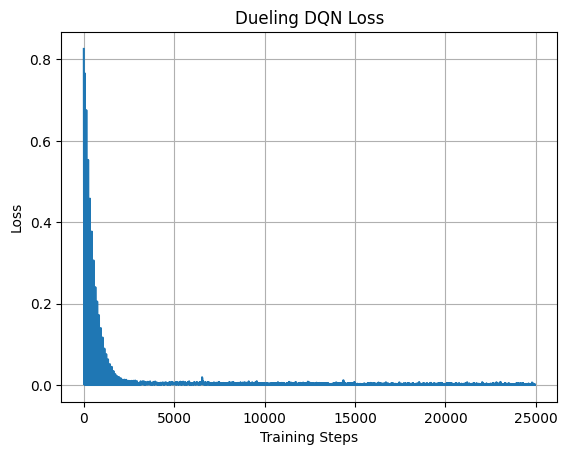

In [26]:
# 2) 訓練函式
def train_dueling_dqn_pure(episodes=500, hidden_size1=150, hidden_size2=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_size = 64
    n_actions = 4
    batch_size = 64
    gamma = 0.9
    learning_rate = 1e-3
    epsilon_start = 1.0
    epsilon_end = 0.1
    mem_size = 2000
    sync_freq = 100
    max_moves = 50

    # 建立 Dueling DQN 網路
    online_model = DuelingDQN(input_size, hidden_size1, hidden_size2, n_actions).to(device)
    target_model = copy.deepcopy(online_model).to(device)
    for p in target_model.parameters():
        p.requires_grad = False

    optimizer = torch.optim.Adam(online_model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # 經驗回放與訓練紀錄
    replay = deque(maxlen=mem_size)
    losses = []
    episode_rewards = []
    episode_steps = []
    epsilon = epsilon_start
    step = 0

    for ep in range(episodes):
        game = Gridworld(size=4, mode='random')
        state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/100.0
        state = torch.from_numpy(state_).float().to(device)

        status, moves, ep_reward = 1, 0, 0

        while status == 1:
            step += 1
            moves += 1

            # ε-greedy
            qval = online_model(state)
            if random.random() < epsilon:
                action = random.randint(0, n_actions - 1)
            else:
                action = torch.argmax(qval).item()

            game.makeMove(action)
            reward = game.reward()
            ep_reward += reward

            next_state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/100.0
            next_state = torch.from_numpy(next_state_).float().to(device)
            done = reward != -1

            replay.append((state, action, reward, next_state, done))
            state = next_state

            # 訓練
            if len(replay) >= batch_size:
                batch = random.sample(replay, batch_size)
                s1_b, a_b, r_b, s2_b, d_b = zip(*batch)

                s1_b = torch.cat(s1_b).to(device)
                a_b = torch.tensor(a_b, dtype=torch.long).to(device)
                r_b = torch.tensor(r_b, dtype=torch.float32).to(device)
                s2_b = torch.cat(s2_b).to(device)
                d_b = torch.tensor(d_b, dtype=torch.float32).to(device)

                Q_pred = online_model(s1_b).gather(1, a_b.unsqueeze(1)).squeeze(1)

                with torch.no_grad():
                    Q_next = target_model(s2_b).max(1)[0]  # 非 Double DQN
                    Q_target = r_b + gamma * Q_next * (1 - d_b)

                loss = loss_fn(Q_pred, Q_target)
                losses.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if step % sync_freq == 0:
                    target_model.load_state_dict(online_model.state_dict())

            if done or moves >= max_moves:
                status = 0

        # epsilon 衰減
        epsilon = max(epsilon_end, epsilon - (epsilon_start - epsilon_end) / episodes)
        episode_rewards.append(ep_reward)
        episode_steps.append(moves)

        if ep % 100 == 0:
            print(f"epoch {ep} | Avg Loss: {np.mean(losses[-100:]):.4f} | Epsilon: {epsilon:.2f} | Reward: {ep_reward}")

    return online_model, losses, episode_rewards, episode_steps
model, losses, rewards, steps = train_dueling_dqn_pure()
plt.plot(losses)
plt.title("Dueling DQN Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.show()